
# Advanced Urban Analytics — Practice Session 1  
## Graph Theory Foundations for Urban Analytics (pre-GNN)

**Theme:** Graph Modelling & Spatial-Explicit GeoAI for Urban Analytics  
**Instructor:** Dr. Pengyuan Liu  
**Session length:** ~2 hours (adjust as needed)

### Learning objectives
By the end of this session, students should be able to:
1. Define graphs, nodes, edges, weights, and direction; distinguish common graph types used in urban analytics.
2. Construct a graph from an edge list and compute key matrices (adjacency, degree, Laplacian).
3. Interpret core concepts: paths, connectivity, components, clustering, assortativity, centrality.
4. Run basic analyses in Python using `networkx` and visualise results.
5. Relate graph-theoretic quantities to urban questions (accessibility, vulnerability, influence, segregation, resilience).

### Prerequisites
- Basic Python (variables, lists, functions)
- Familiarity with urban networks (roads, transit, social networks) is helpful but not required.



## 0. Environment setup

We will use:
- `networkx` for graph construction and algorithms
- `numpy` for matrices
- `matplotlib` for visualisation


In [ ]:
# If needed (e.g., on Colab), uncomment the install lines:
# !pip -q install networkx matplotlib numpy pandas

import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140


In [ ]:
import sys
sys.executable



## 1. What is a graph (in urban analytics)?

A **graph** \(G=(V,E)\) consists of:
- a set of **nodes/vertices** $(V)$ (e.g., intersections, stations, neighbourhoods, people)
- a set of **edges** $(E\subseteq V\times V)$ (e.g., roads, rail links, social ties)

### Common variants in practice
- **Undirected** vs **directed** (one-way streets, flows)
- **Unweighted** vs **weighted** (travel time, distance, capacity)
- **Simple graph** vs **multigraph** (multiple lines between stations)
- **Bipartite** (people–places, trips–stops)
- **Spatially embedded graphs** (nodes have coordinates; edges have geometry)

In GeoAI / GNN settings, graphs are frequently the *structural backbone* that connects observations:
- node features $(\mathbf{X})$ (e.g., land-use mix, income, heat exposure)
- edge features $(\mathbf{E})$ (e.g., travel time, impedance, similarity)
- optional global features $(\mathbf{u})$ (e.g., policy regime, city-level attributes)



## 2. A toy urban network

We will create a small *street-like* network: nodes are intersections, edges are road segments.
Then we will compute basic metrics and discuss their interpretations.


In [ ]:
# A toy edge list (u, v, travel_time_minutes)
edges = [
    ("A", "B", 3.0),
    ("B", "C", 2.0),
    ("C", "D", 4.0),
    ("B", "D", 6.0),
    ("A", "E", 5.0),
    ("E", "F", 2.0),
    ("F", "D", 3.0),
    ("C", "F", 1.5),
]

G = nx.Graph()
G.add_weighted_edges_from(edges, weight="t")

G.nodes(), G.number_of_edges(), G.number_of_nodes()


In [ ]:
# Visualise the toy graph using a deterministic layout
pos = nx.spring_layout(G, seed=7)  # for consistent visuals

plt.figure(figsize=(5.2, 3.8))
nx.draw(G, pos, with_labels=True, node_size=800)
edge_labels = nx.get_edge_attributes(G, "t")
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:g}" for k,v in edge_labels.items()}, font_size=9)
plt.title("Toy urban network (edge labels: travel time in minutes)")
plt.axis("off")
plt.show()



### Discussion prompt
- Which node(s) look like “connectors” between multiple parts of the network?
- If \(t\) is travel time, what does a “shortest path” mean?



## 3. Core representations: edge list, adjacency matrix, degree matrix

### Adjacency matrix $(\mathbf{A})$
For an undirected unweighted graph, $(A_{ij}=1)$ if there is an edge between $(i)$ and $(j)$, else 0.  
For weighted graphs, $(A_{ij})$ can store a weight (e.g., similarity).

### Degree $(k_i)$ and degree matrix $(\mathbf{D})$
$(k_i = \sum_j A_{ij})$. For weighted graphs, one often uses **strength**: $(s_i=\sum_j w_{ij})$.

### Graph Laplacian $(\mathbf{L})$
Unnormalised Laplacian: $(\mathbf{L}=\mathbf{D}-\mathbf{A})$.  
This shows up in diffusion/smoothing, spectral clustering, and as a baseline intuition for message passing.


In [6]:
# Fix node ordering to make matrices interpretable
nodes = sorted(G.nodes())
node_index = {n:i for i,n in enumerate(nodes)}
nodes


['A', 'B', 'C', 'D', 'E', 'F']

In [7]:
# Build unweighted adjacency matrix A (0/1) for structure
A = nx.to_numpy_array(G, nodelist=nodes, weight=None)  # structure only
D = np.diag(A.sum(axis=1))
L = D - A

A, D, L


(array([[0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 1., 0.]]),
 array([[2., 0., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 3.]]),
 array([[ 2., -1.,  0.,  0., -1.,  0.],
        [-1.,  3., -1., -1.,  0.,  0.],
        [ 0., -1.,  3., -1.,  0., -1.],
        [ 0., -1., -1.,  3.,  0., -1.],
        [-1.,  0.,  0.,  0.,  2., -1.],
        [ 0.,  0., -1., -1., -1.,  3.]]))

In [8]:
# Pretty-print as DataFrames
A_df = pd.DataFrame(A, index=nodes, columns=nodes).astype(int)
D_df = pd.DataFrame(D, index=nodes, columns=nodes).astype(int)
L_df = pd.DataFrame(L, index=nodes, columns=nodes).astype(int)

A_df


,A,B,C,D,E,F
A,0,1,0,0,1,0
B,1,0,1,1,0,0
C,0,1,0,1,0,1
D,0,1,1,0,0,1
E,1,0,0,0,0,1
F,0,0,1,1,1,0


In [9]:
D_df


,A,B,C,D,E,F
A,2,0,0,0,0,0
B,0,3,0,0,0,0
C,0,0,3,0,0,0
D,0,0,0,3,0,0
E,0,0,0,0,2,0
F,0,0,0,0,0,3


In [10]:
L_df


,A,B,C,D,E,F
A,2,-1,0,0,-1,0
B,-1,3,-1,-1,0,0
C,0,-1,3,-1,0,-1
D,0,-1,-1,3,0,-1
E,-1,0,0,0,2,-1
F,0,0,-1,-1,-1,3



### Mini exercise
1. Verify that $(\sum_j L_{ij}=0)$ for each row $(i)$. What does that imply?  
2. For a node with high degree, what pattern do you see in its row/column in $(\mathbf{A})$ and $(\mathbf{L})$?



## 4. Paths, distances, connectivity

### Paths and shortest paths
- A **path** is a sequence of edges connecting nodes.
- A **shortest path** depends on the edge weight you choose (distance, time, cost).

### Connectivity and components
- A graph is **connected** if every pair of nodes has a path between them.
- Otherwise it has multiple **connected components**.

Urban relevance:
- Network disruptions (floods, construction, failures) can disconnect areas.
- Components can approximate isolated communities or accessibility deserts.


In [11]:
# Connected components
components = list(nx.connected_components(G))
components


[{'A', 'B', 'C', 'D', 'E', 'F'}]

In [12]:
# Shortest paths: unweighted (fewest edges) vs weighted (min travel time)
print("Unweighted shortest path A -> D:", nx.shortest_path(G, "A", "D"))
print("Weighted shortest path A -> D:", nx.shortest_path(G, "A", "D", weight="t"))
print("Weighted travel time A -> D:", nx.shortest_path_length(G, "A", "D", weight="t"))


Unweighted shortest path A -> D: ['A', 'B', 'D']
Weighted shortest path A -> D: ['A', 'B', 'D']
Weighted travel time A -> D: 9.0



### Teaching note
In urban analytics, you should always be explicit about what "shortest" means:
- Fewest turns/segments? (topological distance)
- Minimum travel time? (impedance-weighted)
- Minimum generalised cost? (time + price + transfer penalties)



## 5. Centrality measures (why some nodes matter more)

Centrality is a family of measures that quantify “importance” or “influence” in a network.

Common options:
- **Degree centrality:** number of neighbours (local connectivity)
- **Betweenness centrality:** fraction of shortest paths passing through a node (broker/bridge)
- **Closeness centrality:** inverse distance to others (accessibility-like)
- **Eigenvector centrality:** connected to important nodes (influence via influential neighbours)
- **PageRank:** a random-walk importance measure (commonly for directed graphs)

Urban interpretations:
- High betweenness nodes can be critical intersections; failures can cause large rerouting impacts.
- Closeness can approximate central accessibility within a network (depending on weights).


In [14]:
# Centrality on the toy graph (unweighted vs weighted variants)
deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G, weight="t", normalized=True)
close_cent = nx.closeness_centrality(G, distance="t")
eig_cent = nx.eigenvector_centrality_numpy(G, weight=None)  # structure-based

centrality_df = pd.DataFrame({
    "degree_centrality": deg_cent,
    "betweenness (weighted by t)": bet_cent,
    "closeness (weighted by t)": close_cent,
    "eigenvector (structure)": eig_cent,
}).loc[nodes].sort_values("betweenness (weighted by t)", ascending=False)

centrality_df


,degree_centrality,betweenness (weighted by t),closeness (weighted by t),eigenvector (structure)
C,0.6,0.4,0.312500,0.493603
B,0.6,0.3,0.250000,0.442092
F,0.6,0.3,0.303030,0.442092
A,0.4,0.0,0.175439,0.246801
D,0.6,0.0,0.185185,0.493603
E,0.4,0.0,0.238095,0.246801


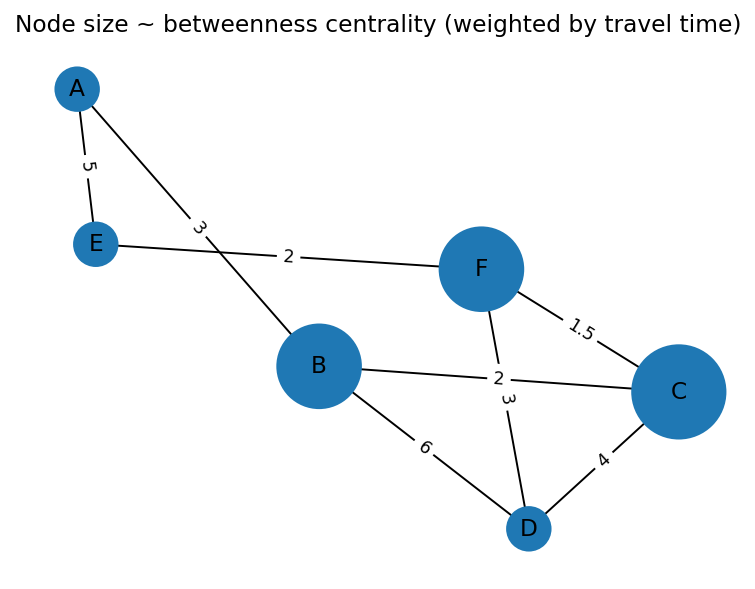

In [15]:
# Visualise betweenness as node size
sizes = [500 + 4500 * bet_cent[n] for n in nodes]

plt.figure(figsize=(5.2, 3.8))
nx.draw(G, pos, with_labels=True, node_size=sizes)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:g}" for k,v in edge_labels.items()}, font_size=9)
plt.title("Node size ~ betweenness centrality (weighted by travel time)")
plt.axis("off")
plt.show()



### Mini exercise
- Which node has the highest betweenness? Can you explain *structurally* why?
- If we delete that node (simulate disruption), what happens to connectivity and travel times?


In [16]:
# Disruption simulation: remove the highest-betweenness node
critical_node = max(bet_cent, key=bet_cent.get)
critical_node


'C'

In [18]:
G_removed = G.copy()
G_removed.remove_node(critical_node)

list(nx.connected_components(G_removed)), nx.is_connected(G_removed)


([{'A', 'B', 'D', 'E', 'F'}], True)

In [19]:
# Compare shortest travel time A -> D before/after, if feasible
def safe_shortest_time(graph, s, t, weight="t"):
    try:
        return nx.shortest_path_length(graph, s, t, weight=weight)
    except nx.NetworkXNoPath:
        return math.inf

before = safe_shortest_time(G, "A", "D", "t")
after = safe_shortest_time(G_removed, "A", "D", "t")

before, after


(9.0, 9.0)


## 6. Clustering and triadic closure

The **clustering coefficient** measures how likely it is that two neighbours of a node are connected.

Urban relevance:
- In street networks, clustering relates to local route redundancy.
- In social networks, clustering relates to community formation and potential echo chambers.


In [20]:
clustering = nx.clustering(G)  # unweighted clustering
pd.Series(clustering).loc[nodes].sort_values(ascending=False)


D    0.666667
C    0.666667
F    0.333333
B    0.333333
A    0.000000
E    0.000000
dtype: float64


## 7. From graph theory to GNN intuition (bridge to Session 2)

A common (simplified) view of message passing in GNNs is:

$[
\mathbf{H}^{(\ell+1)} = \sigma\big( \tilde{\mathbf{D}}^{-1/2} \tilde{\mathbf{A}} \tilde{\mathbf{D}}^{-1/2} \mathbf{H}^{(\ell)} \mathbf{W}^{(\ell)} \big)
]$

where $(\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I})$ adds self-loops, and $(\tilde{\mathbf{D}})$ is its degree matrix.

Key idea:
- $(\mathbf{A})$ encodes who can “talk to whom” (neighbourhood structure).
- Normalisation stabilises scale across nodes with different degrees.
- Repeated layers propagate information further through the graph (multi-hop context).

In the next session, we will build:
- a street-network graph (or another spatial graph),
- node features,
- and train a GNN for an urban prediction task (classification/regression).



## 8. Optional extension (homework / extra practice)

1. Convert this undirected graph to a **directed** graph with one-way links and recompute PageRank.  
2. Replace travel time with **similarity** weights and see how shortest paths stop making sense, while spectral ideas become more relevant.  
3. Construct a **k-nearest neighbour** graph on synthetic coordinates (spatial graph) and compare metrics across k.

Below is a small template for (3).


In [21]:
# Optional extension: build a spatial kNN graph on synthetic coordinates
rng = np.random.default_rng(42)
coords = pd.DataFrame({
    "node": [f"N{i}" for i in range(1, 16)],
    "x": rng.uniform(0, 1, 15),
    "y": rng.uniform(0, 1, 15),
}).set_index("node")

coords.head()


,x,y
node,,
N1,0.773956,0.227239
N2,0.438878,0.554585
N3,0.858598,0.063817
N4,0.697368,0.827631
N5,0.094177,0.631664


In [22]:
def knn_graph_from_coords(df, k=3):
    nodes = df.index.tolist()
    XY = df[["x", "y"]].to_numpy()
    Gk = nx.Graph()
    Gk.add_nodes_from(nodes)

    # Pairwise Euclidean distances
    dists = np.sqrt(((XY[:, None, :] - XY[None, :, :]) ** 2).sum(axis=2))

    for i, u in enumerate(nodes):
        # Exclude self, take k nearest
        nn_idx = np.argsort(dists[i])[1:k+1]
        for j in nn_idx:
            v = nodes[j]
            Gk.add_edge(u, v, dist=float(dists[i, j]))
    return Gk

Gk = knn_graph_from_coords(coords, k=3)
nx.is_connected(Gk), Gk.number_of_nodes(), Gk.number_of_edges()


(True, 15, 28)

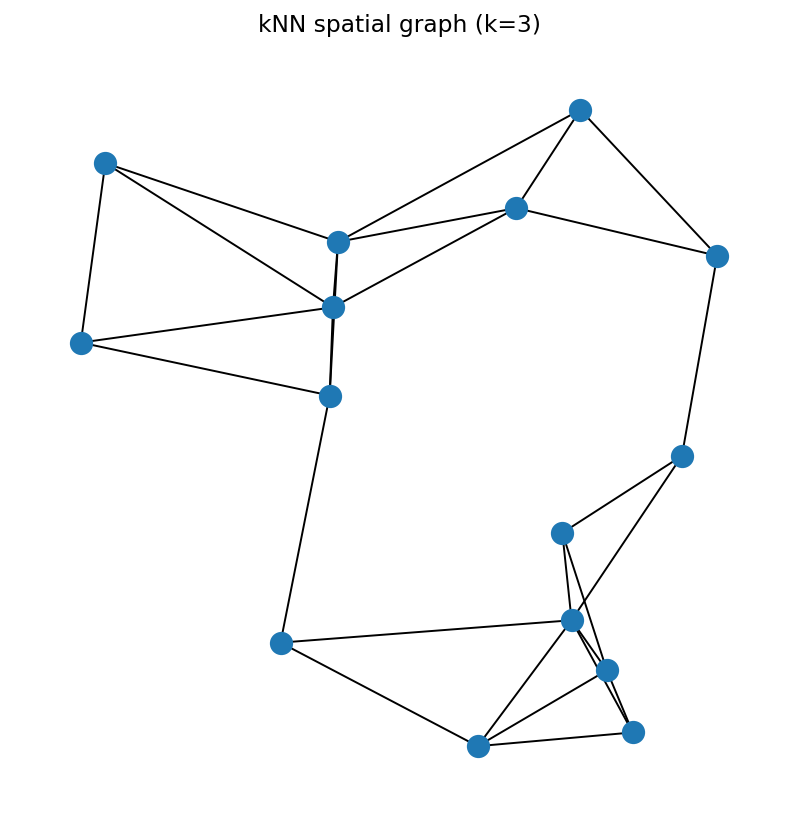

In [23]:
# Visualise kNN graph
pos_k = {n: coords.loc[n, ["x", "y"]].to_numpy() for n in coords.index}

plt.figure(figsize=(5.5, 5.5))
nx.draw(Gk, pos_k, with_labels=False, node_size=120)
plt.title("kNN spatial graph (k=3)")
plt.axis("off")
plt.show()


## 9. Building graphs from a GeoJSON using spatial weights (Queen vs Rook)

In spatial analysis, **contiguity-based spatial weights** are a standard way to define neighbourhood structure:

- **Queen contiguity:** two polygons are neighbours if they **touch at least at a point** (edge or corner).
- **Rook contiguity:** two polygons are neighbours only if they **share a boundary segment** (edge adjacency).

Urban analytics relevance:
- Queen weights typically produce denser neighbourhood graphs (more connections).
- Rook weights are more conservative and may better reflect “shared-border” interactions.

In this section we will:
1. Load a GeoJSON of polygons.
2. Construct Queen and Rook adjacency graphs.
3. Visualise and compare the resulting graphs.


In [25]:
# If you do not already have these packages, install them (e.g., on Colab):
# !pip -q install geopandas shapely pyproj rtree

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon


In [26]:
# Load GeoJSON (provided with the teaching materials)
geojson_path = "OA_Subset.geojson"
gdf = gpd.read_file(geojson_path)

gdf.head()


d:\PythonAnaconda13\envs\black3\Lib\site-packages\pyogrio\core.py:34: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


,OA21CD,geometry
0,E00003601,"MULTIPOLYGON (((533941.857 170548.083, 533866...."
1,E00003605,"MULTIPOLYGON (((533703.755 170359.021, 533730...."
2,E00003611,"MULTIPOLYGON (((533874.07 170328.2, 533874.804..."
3,E00003613,"MULTIPOLYGON (((533772.582 170551.621, 533772...."
4,E00003616,"MULTIPOLYGON (((533681.74 170450.306, 533722.7..."


In [27]:
# Ensure geometry is valid; fix common issues where possible
gdf = gdf.copy()
gdf["geometry"] = gdf["geometry"].buffer(0)  # fixes many self-intersections
gdf = gdf[gdf.geometry.notnull()].reset_index(drop=True)

# If there is a useful ID column, use it; otherwise create one
candidate_id_cols = [c for c in gdf.columns if c.lower() in {"oa", "oa_code", "code", "id", "gid", "name"}]
id_col = candidate_id_cols[0] if candidate_id_cols else None

if id_col is None:
    gdf["unit_id"] = [f"U{i}" for i in range(len(gdf))]
    id_col = "unit_id"

gdf[[id_col, "geometry"]].head()


,unit_id,geometry
0,U0,"POLYGON ((533941.857 170548.083, 533866.327 17..."
1,U1,"POLYGON ((533703.755 170359.021, 533730.922 17..."
2,U2,"POLYGON ((533874.07 170328.2, 533874.804 17026..."
3,U3,"POLYGON ((533772.582 170551.621, 533772.647 17..."
4,U4,"POLYGON ((533681.74 170450.306, 533722.743 170..."


In [28]:
# Helper: build Queen and Rook adjacency using GeoPandas spatial index
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_contiguity_graph(polys_gdf: gpd.GeoDataFrame, id_col: str, kind: str = "queen") -> nx.Graph:
    """Build a contiguity graph from polygon geometries.

    Queen: touches at a point or edge.
    Rook: shares a boundary segment (non-zero length).
    """
    assert kind in {"queen", "rook"}
    Gc = nx.Graph()
    Gc.add_nodes_from(polys_gdf[id_col].tolist())

    sindex = polys_gdf.sindex
    geoms = polys_gdf.geometry.values
    ids = polys_gdf[id_col].values

    for i, geom_i in enumerate(geoms):
        cand_idx = list(sindex.intersection(geom_i.bounds))
        for j in cand_idx:
            if j <= i:
                continue
            geom_j = geoms[j]

            if kind == "queen":
                if geom_i.touches(geom_j):
                    Gc.add_edge(ids[i], ids[j])
            else:  # rook
                inter = geom_i.boundary.intersection(geom_j.boundary)
                if (not inter.is_empty) and getattr(inter, "length", 0.0) > 0:
                    Gc.add_edge(ids[i], ids[j])

    return Gc

G_queen = build_contiguity_graph(gdf, id_col=id_col, kind="queen")
G_rook  = build_contiguity_graph(gdf, id_col=id_col, kind="rook")

(G_queen.number_of_nodes(), G_queen.number_of_edges(),
 G_rook.number_of_nodes(), G_rook.number_of_edges())


(1193, 3446, 1193, 3345)

In [29]:
# Compare connectivity
print("Queen connected?", nx.is_connected(G_queen))
print("Rook connected? ", nx.is_connected(G_rook))
print("\nQueen components:", nx.number_connected_components(G_queen))
print("Rook components: ", nx.number_connected_components(G_rook))


Queen connected? True
Rook connected?  True

Queen components: 1
Rook components:  1


<Figure size 868x868 with 0 Axes>

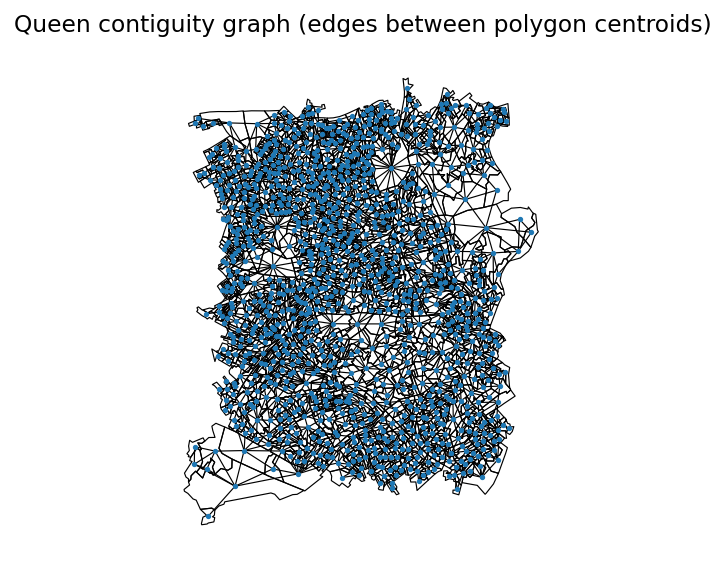

<Figure size 868x868 with 0 Axes>

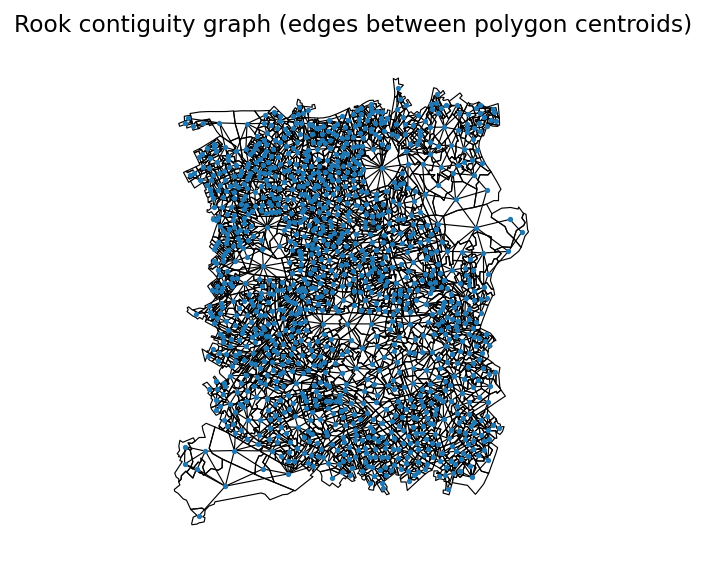

In [30]:
# Visualise adjacency graphs on the map (edges drawn between polygon centroids)
gdf["centroid"] = gdf.geometry.centroid
centroid_pos = {row[id_col]: (row["centroid"].x, row["centroid"].y) for _, row in gdf.iterrows()}

def plot_map_with_graph(polys_gdf, graph, title):
    plt.figure(figsize=(6.2, 6.2))
    ax = polys_gdf.plot(edgecolor="black", linewidth=0.6, facecolor="none")
    nx.draw(graph, pos=centroid_pos, node_size=3, width=0.6, ax=ax)
    plt.title(title)
    plt.axis("off")
    plt.show()

plot_map_with_graph(gdf, G_queen, "Queen contiguity graph (edges between polygon centroids)")
plot_map_with_graph(gdf, G_rook,  "Rook contiguity graph (edges between polygon centroids)")


### Discussion prompts (spatial weights)
Which graph is denser? Why is that expected? (You may find difficult to say through the example here, try with other geojson file of your interets!)



## 10. Downloading and visualising Glasgow street networks with OSMnx

For many urban analytics tasks, **street networks** are a natural graph:
- nodes: intersections / endpoints
- edges: street segments (can include length, travel time, road type, etc.)

In this section we will:
1. Use **OSMnx** to download Glasgow’s street network from OpenStreetMap.
2. Visualise the network.
3. Convert it to a NetworkX graph for analysis.

Note:
- This requires an internet connection at runtime.
- OSM data quality varies; always sanity-check results.


In [31]:
# If needed:
!pip -q install osmnx

import osmnx as ox


In [32]:
# Configure OSMnx (optional)
ox.settings.log_console = True
ox.settings.use_cache = True


In [33]:
# Download Glasgow street network (drivable by default)
# Alternative network_type: "walk", "bike", "all"
place_name = "Glasgow"
G_drive = ox.graph_from_place(place_name, network_type="drive")
G_drive


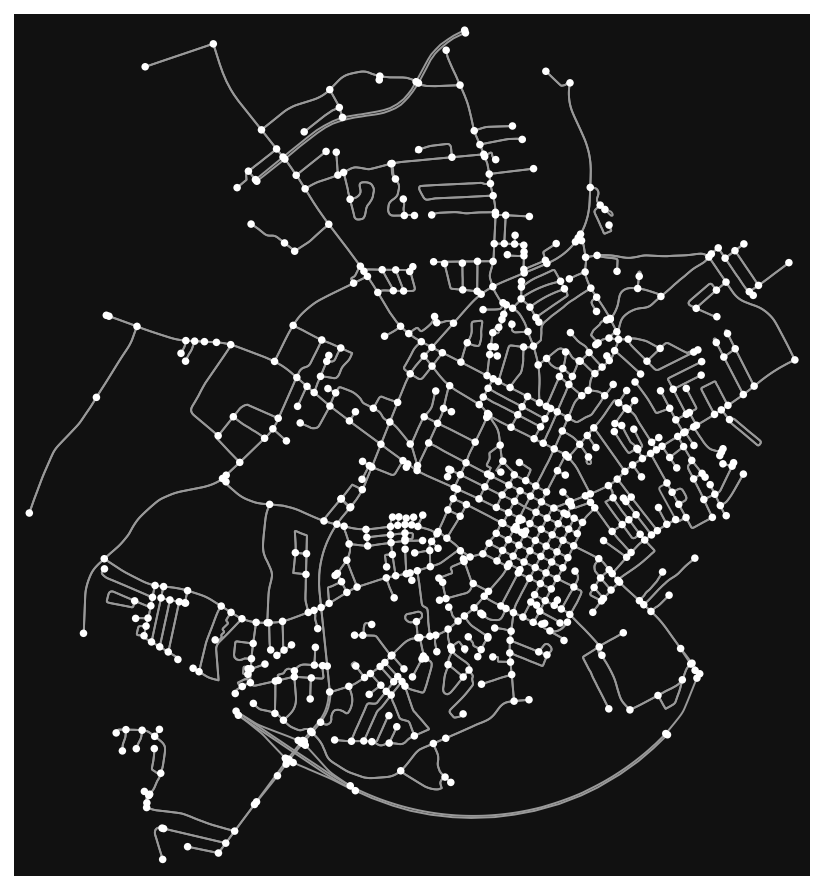

In [34]:
# Visualise (street network plot)
fig, ax = ox.plot_graph(G_drive, show=False, close=False)
plt.show()


In [35]:
# Basic network summary statistics
stats = ox.basic_stats(G_drive)
{k: stats[k] for k in ["n", "m", "street_length_total", "circuity_avg", "intersection_count"] if k in stats}


{'n': 778,
 'm': 1996,
 'street_length_total': 195419.27492369703,
 'circuity_avg': 1.0897737465803372,
 'intersection_count': 615}

In [36]:
from osmnx import convert

# Convert to undirected graph for some classic graph metrics (optional)
G_drive_undirected = convert.to_undirected(G_drive)

largest_cc = max(nx.connected_components(G_drive_undirected), key=len)
G_lcc = G_drive_undirected.subgraph(largest_cc).copy()

G_lcc.number_of_nodes(), G_lcc.number_of_edges()


(778, 1034)

In [37]:
# Example metric (keep in mind: some metrics can be expensive on large graphs)
deg_cent_lcc = nx.degree_centrality(G_lcc)
top10 = sorted(deg_cent_lcc.items(), key=lambda x: x[1], reverse=True)[:10]
top10


[(161697710, 0.005148005148005148),
 (161697729, 0.005148005148005148),
 (161697789, 0.005148005148005148),
 (161697858, 0.005148005148005148),
 (161707803, 0.005148005148005148),
 (161707807, 0.005148005148005148),
 (161711977, 0.005148005148005148),
 (161712562, 0.005148005148005148),
 (161714564, 0.005148005148005148),
 (161717855, 0.005148005148005148)]

For street graphs, always clarify:
- Is the graph **primal** (intersections as nodes) or **dual** (streets as nodes)?
- Are you using **directed** edges (one-way restrictions) or undirected?
- Are weights based on **length**, **travel time**, or **impedance**?
- Are you analysing the whole city, or a sub-area (e.g., a neighbourhood buffer)?

Try out Different cities of your interests!


## End of Session 1

**Next session preview:** From graph theory to **Graph Neural Networks**: node features, edge weights, spatial graphs, and a compact GNN training pipeline for an urban analytics task.
